In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Making required image directory of 1/4th of total images

In [3]:
import os
import shutil

def delete_three_fourth_images(input_folder, output_folder):
    # Get list of all files in the input folder
    files = os.listdir(input_folder)
    
    # Calculate how many images to delete
    num_images = len(files)
    num_images_to_delete = num_images * 1 // 4
    
    # Sort files based on modification time (you can choose another criterion)
    files.sort(key=lambda x: os.path.getmtime(os.path.join(input_folder, x)))
    
    # Move the first three-fourth images to the output folder
    for i in range(num_images_to_delete):
        file_to_move = os.path.join(input_folder, files[i])
        shutil.copy(file_to_move, output_folder)
    
# Example usage:
input_folder = "/kaggle/input/vqa-images/train2014"
output_folder = "/kaggle/working/vqa-images/train2014"  # Choose a writable directory
os.makedirs(output_folder, exist_ok=True)
delete_three_fourth_images(input_folder, output_folder)


# Reading Question dataset and Annotations Dataset

In [4]:
import json


df_ques = json.load(open('/kaggle/input/questions/v2_OpenEnded_mscoco_train2014_questions.json', 'r'))
df_annot=json.load(open('/kaggle/input/virtualqa/v2_mscoco_train2014_annotations.json', 'r'))

### Inspecting length of question dataset and annotation dataset

In [5]:
print("Total no. of question are",len(df_ques['questions']))
print("Total no. of answers are",len(df_annot['annotations']))

Total no. of question are 443757
Total no. of answers are 443757


In [6]:
df_annot['annotations'][:3]

[{'question_type': 'what is this',
  'multiple_choice_answer': 'net',
  'answers': [{'answer': 'net', 'answer_confidence': 'maybe', 'answer_id': 1},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 2},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 3},
   {'answer': 'netting', 'answer_confidence': 'yes', 'answer_id': 4},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 5},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 6},
   {'answer': 'mesh', 'answer_confidence': 'maybe', 'answer_id': 7},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 8},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 9},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 10}],
  'image_id': 458752,
  'answer_type': 'other',
  'question_id': 458752000},
 {'question_type': 'what',
  'multiple_choice_answer': 'pitcher',
  'answers': [{'answer': 'pitcher',
    'answer_confidence': 'yes',
    'answer_id': 1},
   {'answer': 'c

### Making dataset by combining the above two datasets

In [7]:
from tqdm import tqdm

subtype='train2014'
data=[]
imdir='%s/COCO_%s_%012d.jpg'
for i in tqdm(range(len(df_annot['annotations']))):
    answ=df_annot['annotations'][i]['multiple_choice_answer']
    im_path=imdir%(subtype,subtype,df_annot['annotations'][i]['image_id'])
    ques=df_ques['questions'][i]['question']
    ques_type=df_annot['annotations'][i]['question_type']
    ans_type=df_annot['annotations'][i]['answer_type']
    data.append({'im_path':im_path,'ques':ques,'answ':answ, 'quest_type':ques_type, 'ans_type':ans_type })
total_data=pd.DataFrame(data)

100%|██████████| 443757/443757 [00:01<00:00, 330731.57it/s]


In [8]:
total_data.head()

,im_path,ques,answ,quest_type,ans_type
0,train2014/COCO_train2014_000000458752.jpg,What is this photo taken looking through?,net,what is this,other
1,train2014/COCO_train2014_000000458752.jpg,What position is this man playing?,pitcher,what,other
2,train2014/COCO_train2014_000000458752.jpg,What color is the players shirt?,orange,what color is the,other
3,train2014/COCO_train2014_000000458752.jpg,Is this man a professional baseball player?,yes,is this,yes/no
4,train2014/COCO_train2014_000000262146.jpg,What color is the snow?,white,what color is the,other


In [9]:
total_data.shape

(443757, 5)

In [10]:
total_data.iloc[0,0]

'train2014/COCO_train2014_000000458752.jpg'

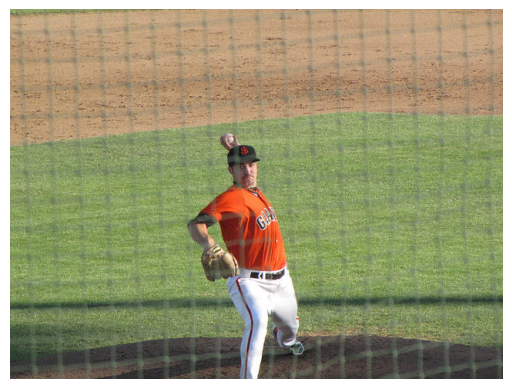

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 

temp_image_path = '/kaggle/input/vqa-images/train2014/COCO_train2014_000000458752.jpg'  

# Load and display the image using Matplotlib
img = mpimg.imread(temp_image_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()


In [12]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
preprocessed_questions = []
for question in tqdm(total_data['ques'].values):
    que = decontracted(question) 
    preprocessed_questions.append(que.lower().strip())
total_data['ques']=preprocessed_questions

100%|██████████| 443757/443757 [00:06<00:00, 68770.97it/s]


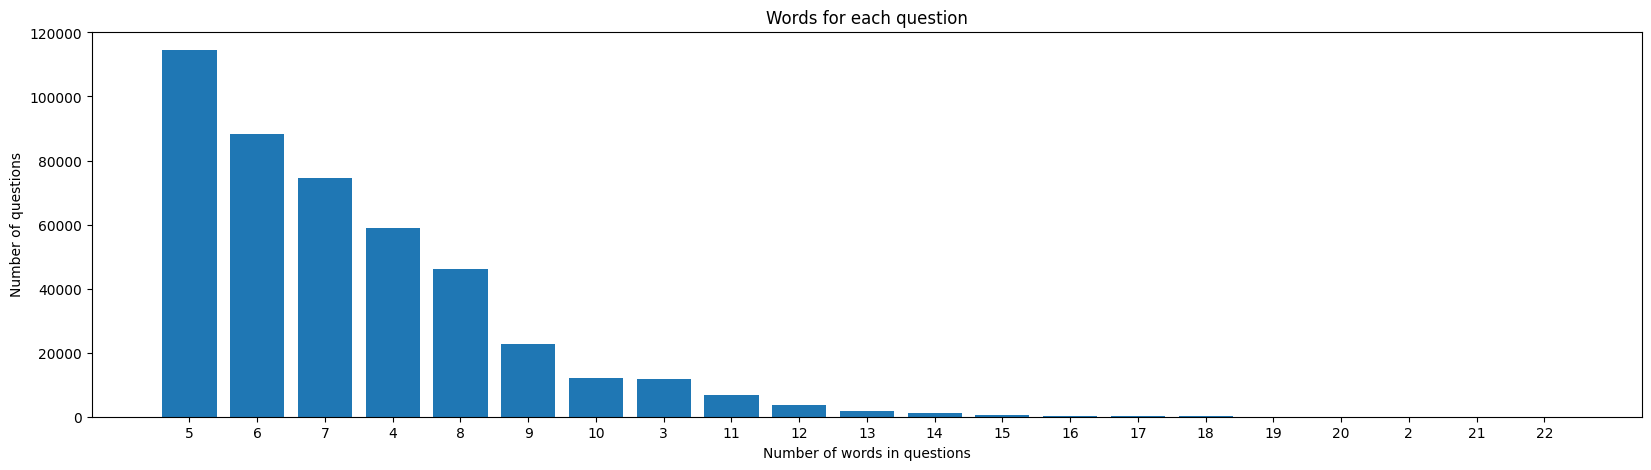

In [13]:
import matplotlib.pyplot as plt

word_count = total_data['ques'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1],reverse=True))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of questions')
plt.xlabel('Number of words in questions')
plt.title('Words for each question')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

#### **Observation**: Maximum questions are in 4-8 words

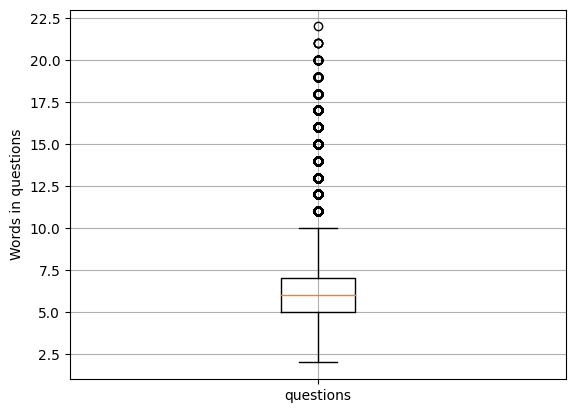

In [14]:
que_word_count = total_data['ques'].str.split().apply(len)
plt.boxplot(que_word_count)
plt.xticks([1], ['questions'])  # Specify tick and label
plt.ylabel('Words in questions')
plt.grid()
plt.show()


#### **Observation**: 50% of questions have 5 to 8 words.

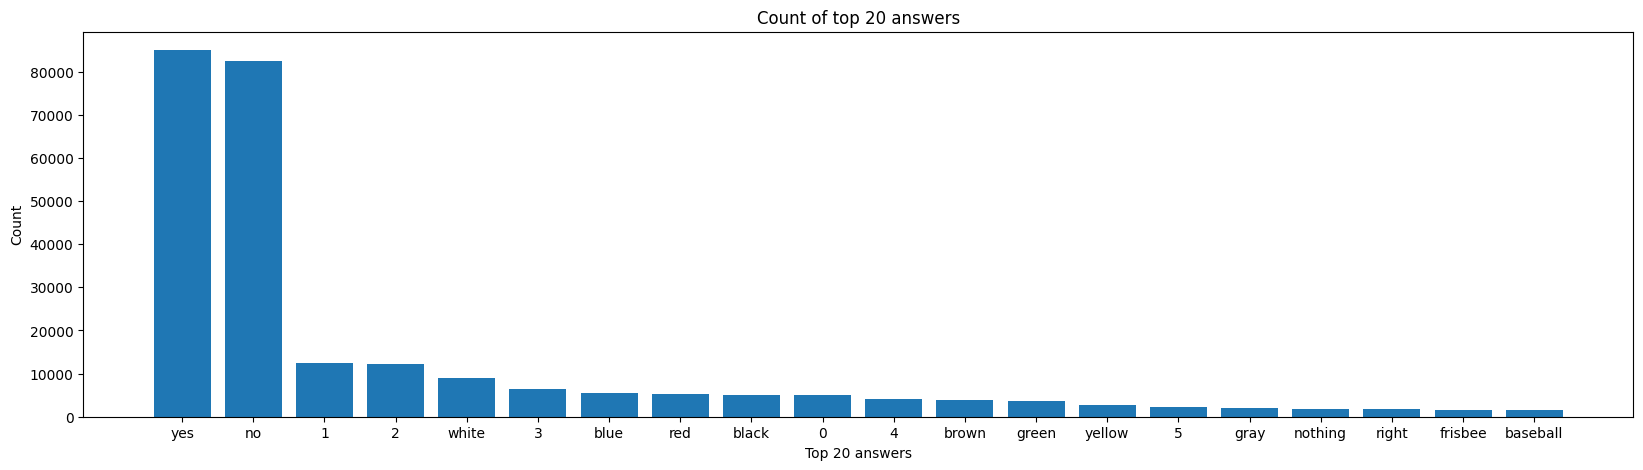

In [15]:
word_count = total_data['answ'].value_counts()[0:20]
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1],reverse=True))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Count')
plt.xlabel('Top 20 answers')
plt.title('Count of top 20 answers')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

#### **Observatons:**
1. Very large proportion of the answer has yes/no answer.

2. Apart from binary answers most common answers consists of either colors or numbers

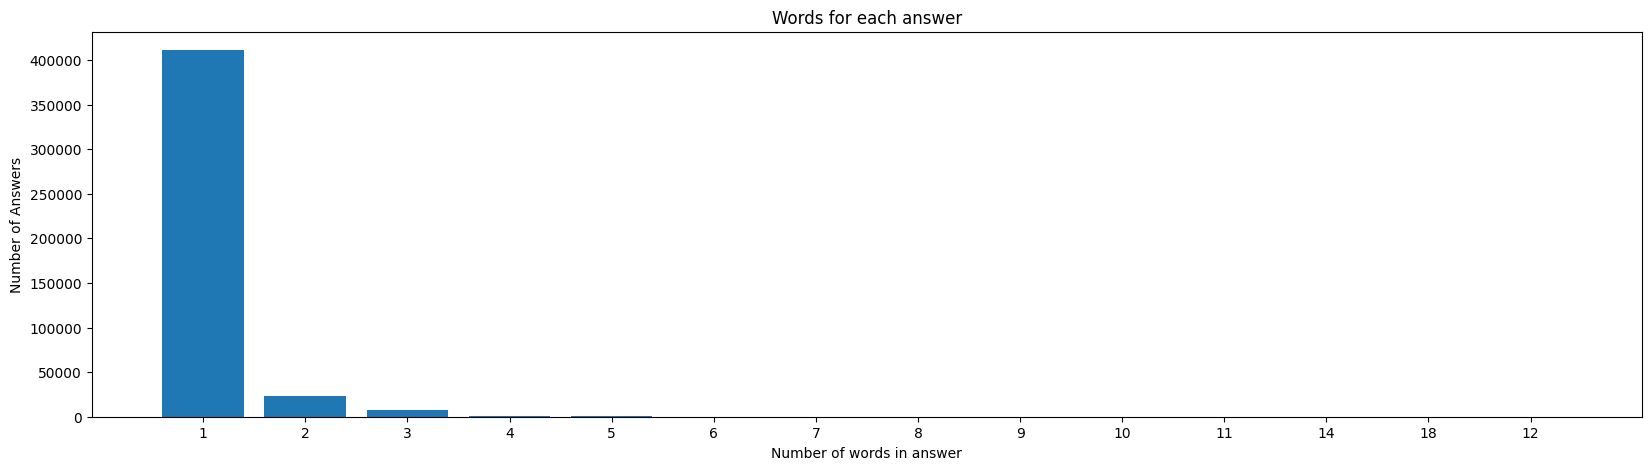

In [16]:
import matplotlib.pyplot as plt

word_count = total_data['answ'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1],reverse=True))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of Answers')
plt.xlabel('Number of words in answer')
plt.title('Words for each answer')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

#### **Observations**:
Most of the answers are one worded

In [17]:
cnt1 = total_data[total_data['answ'] == 'yes']['answ'].count() + total_data[total_data['answ'] == 'no']['answ'].count()
cnt2 = len(total_data) - cnt1
print("Total number of binary (yes/no) answers:", cnt1)
print("% of binary answers:", np.round(cnt1 / len(total_data) * 100, 2))
print("Total number of multiple answers:", cnt2)
print("% of multiple answers:", np.round(cnt2 / len(total_data) * 100, 2))


Total number of binary (yes/no) answers: 167494
% of binary answers: 37.74
Total number of multiple answers: 276263
% of multiple answers: 62.26


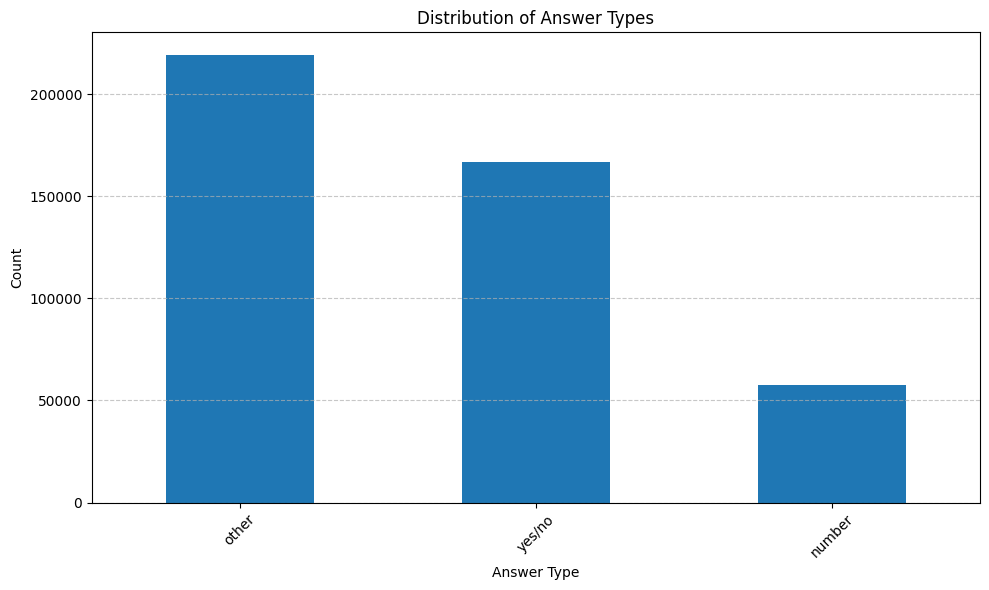

In [18]:
import matplotlib.pyplot as plt

# Group by 'ans_type' and count the occurrences
ans_type_counts = total_data['ans_type'].value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
ans_type_counts.plot(kind='bar')
plt.title('Distribution of Answer Types')
plt.xlabel('Answer Type')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


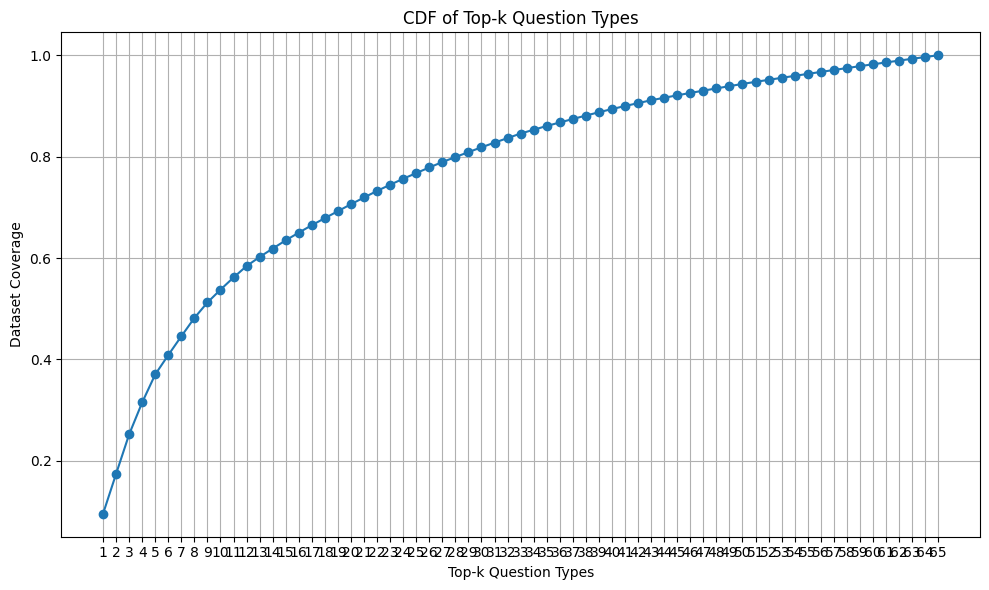

In [19]:
import matplotlib.pyplot as plt

# Calculate coverage of each question type
question_type_coverage = total_data['quest_type'].value_counts(normalize=True)

# Sort question types based on coverage
sorted_question_types = question_type_coverage.sort_values(ascending=False)

# Calculate cumulative sum of coverage
cdf = sorted_question_types.cumsum()

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cdf) + 1), cdf.values, marker='o', linestyle='-')
plt.title('CDF of Top-k Question Types')
plt.xlabel('Top-k Question Types')
plt.ylabel('Dataset Coverage')
plt.grid(True)
plt.xticks(range(1, len(cdf) + 1))
plt.tight_layout()
plt.show()


#### **Observations**:
There isn't a notable bias in the distribution of question types, suggesting that the majority of questions are spread out across various types rather than being concentrated in a few specific categories.

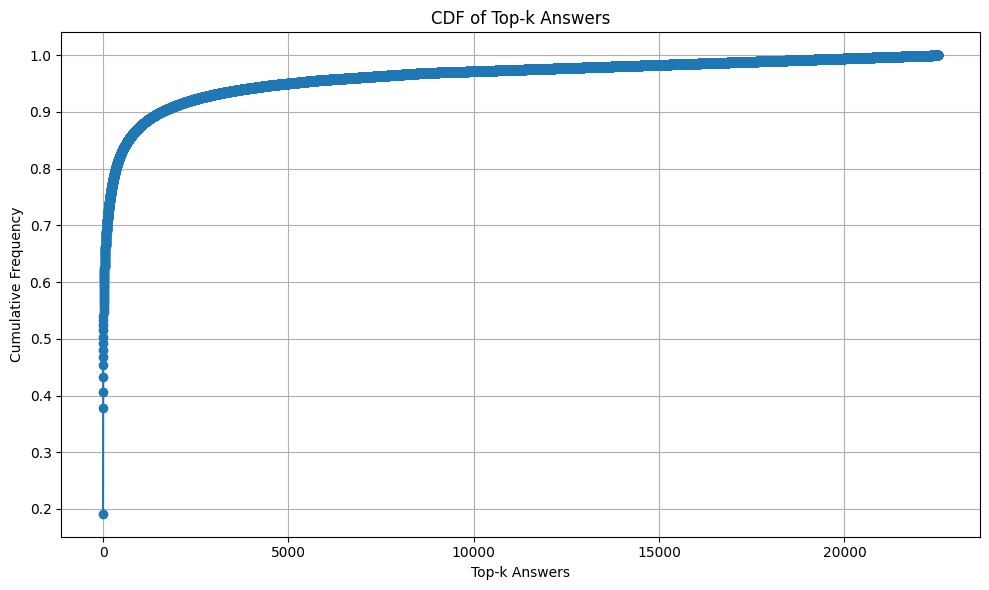

In [20]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named total_data_subset with a column 'answ' containing answers

# Calculate the frequency of each answer
answer_frequency = total_data['answ'].value_counts(normalize=True)

# Sort answers based on frequency
sorted_answers = answer_frequency.sort_values(ascending=False)

# Calculate cumulative sum of frequencies
cdf = sorted_answers.cumsum()

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cdf) + 1), cdf.values, marker='o', linestyle='-')
plt.title('CDF of Top-k Answers')
plt.xlabel('Top-k Answers')
plt.ylabel('Cumulative Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


#### **Observations**:
Almost 95% of answers are one word answers although few questions have 2,3 and 4 word answers.

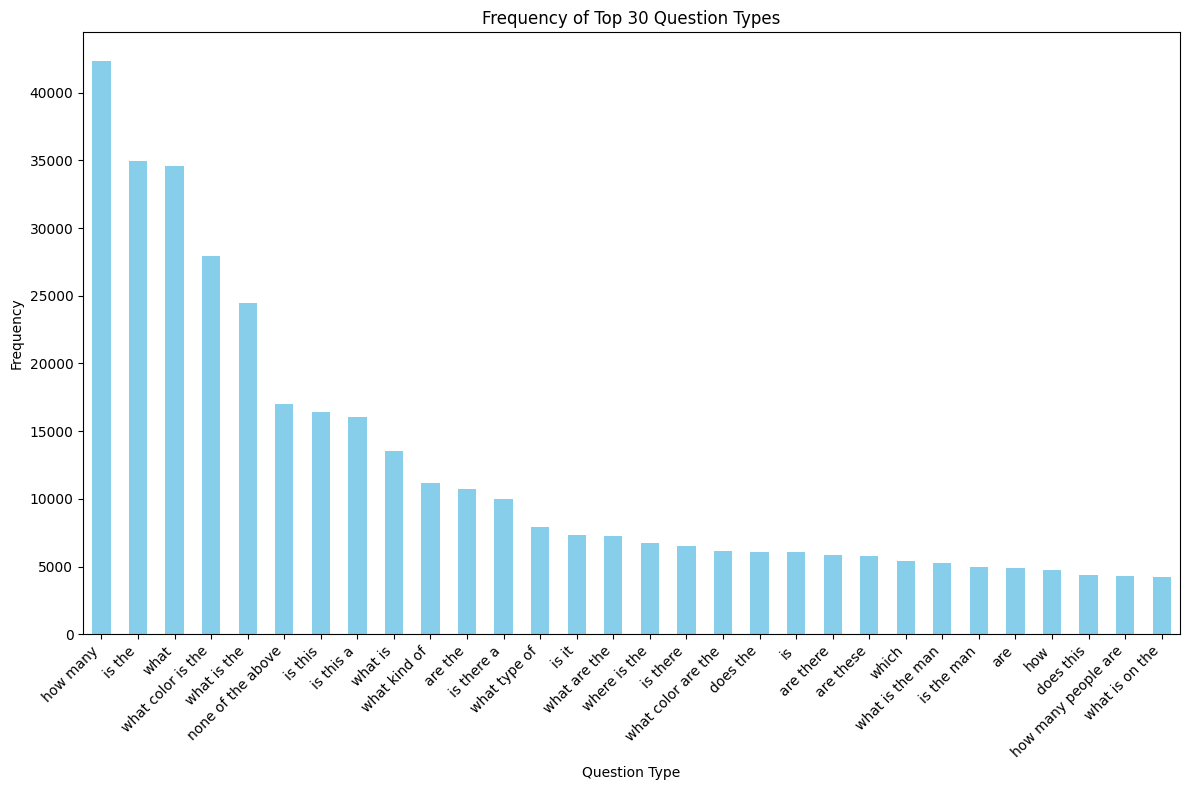

In [21]:
import matplotlib.pyplot as plt

# Get the top 30 question types by frequency
top_30_question_types = total_data['quest_type'].value_counts().nlargest(30)

# Plot the bar graph
plt.figure(figsize=(12, 8))
top_30_question_types.plot(kind='bar', color='skyblue')
plt.title('Frequency of Top 30 Question Types')
plt.xlabel('Question Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


## Taking datas with one word answers

In [22]:
def count_words(text):
    return len(text.split())

# Add a column with the word count
total_data['word_count'] = total_data['answ'].apply(count_words)

# Define the word count threshold (e.g., select rows with more than 2 words)
word_count_threshold = 1

# Filter the DataFrame based on the word count
filtered_df = total_data[total_data['word_count'] == word_count_threshold]

# Drop the temporary 'word_count' column if not needed
df=filtered_df.drop(['quest_type','ans_type','word_count'],axis=1)

In [23]:
df.head()

,im_path,ques,answ
0,train2014/COCO_train2014_000000458752.jpg,what is this photo taken looking through?,net
1,train2014/COCO_train2014_000000458752.jpg,what position is this man playing?,pitcher
2,train2014/COCO_train2014_000000458752.jpg,what color is the players shirt?,orange
3,train2014/COCO_train2014_000000458752.jpg,is this man a professional baseball player?,yes
4,train2014/COCO_train2014_000000262146.jpg,what color is the snow?,white


In [24]:
df.shape

(411198, 3)

#### Taking those datas which have images from our required image directory

In [25]:
import os
import pandas as pd



# Define the directory path where the images are located
image_directory = '/kaggle/working/vqa-images/train2014'

# Get the list of image files in the directory
image_files = os.listdir(image_directory)

# Extract image names from the full path
image_names = [os.path.basename(file) for file in image_files]

# Filter rows based on whether the im_path values are present in the image directory path
filtered_df = df[df['im_path'].apply(lambda x: os.path.basename(x) in image_names)]




In [26]:
filtered_df.shape

(102937, 3)

In [27]:
df = filtered_df

In [28]:
df.shape

(102937, 3)

In [29]:
df = df[['ques', 'answ', 'im_path']]


In [30]:
df.head()

,ques,answ,im_path
32,what color is the jacket?,green,train2014/COCO_train2014_000000131084.jpg
33,is the man riding on a dirt path?,yes,train2014/COCO_train2014_000000131084.jpg
34,what is the man riding on?,motorcycle,train2014/COCO_train2014_000000131084.jpg
35,what is on the pillow?,gray,train2014/COCO_train2014_000000131074.jpg
36,how many pieces of furniture which are used fo...,2,train2014/COCO_train2014_000000131074.jpg


In [31]:
df['im_path']=df['im_path'] = df['im_path'].apply(lambda x: '/kaggle/input/vqa-images/' + x)

## Train Test Split

In [32]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.1, random_state=30)


In [33]:
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=30)



In [34]:
train_df.head()

,ques,answ,im_path
182551,where is the baby?,counter,/kaggle/input/vqa-images/train2014/COCO_train2...
144561,what color is the shade in the background?,multi,/kaggle/input/vqa-images/train2014/COCO_train2...
278770,why is the middle man crouching?,catcher,/kaggle/input/vqa-images/train2014/COCO_train2...
375657,what fruit is in the picture?,apple,/kaggle/input/vqa-images/train2014/COCO_train2...
111142,does that geometric box have tourist information?,yes,/kaggle/input/vqa-images/train2014/COCO_train2...


In [35]:
train_df.shape

(74114, 3)

In [36]:
val_df.head()

,ques,answ,im_path
81036,is the man wearing tennis clothes?,no,/kaggle/input/vqa-images/train2014/COCO_train2...
276985,which boy was just at bat?,crawford,/kaggle/input/vqa-images/train2014/COCO_train2...
146597,where is the cat sleeping?,laptop,/kaggle/input/vqa-images/train2014/COCO_train2...
440193,is there toilet paper?,yes,/kaggle/input/vqa-images/train2014/COCO_train2...
244927,are there fish in the picture?,yes,/kaggle/input/vqa-images/train2014/COCO_train2...


In [37]:
val_df.shape

(10294, 3)

In [38]:
test_df.head()

,ques,answ,im_path
350182,what is strapped to the bike?,umbrella,/kaggle/input/vqa-images/train2014/COCO_train2...
300769,where is the location?,zoo,/kaggle/input/vqa-images/train2014/COCO_train2...
93578,what hairstyle is she wearing?,ponytail,/kaggle/input/vqa-images/train2014/COCO_train2...
77547,how many beds?,1,/kaggle/input/vqa-images/train2014/COCO_train2...
107354,are the dogs twins?,no,/kaggle/input/vqa-images/train2014/COCO_train2...


In [39]:
test_df.shape

(18529, 3)

## Label Encoder

In [40]:
import joblib

from sklearn.preprocessing import LabelEncoder

# # Combine the 'answers' columns from both DataFrames
combined_answers = pd.concat([train_df['answ'], val_df['answ'], test_df['answ']], axis=0)

# Initialize LabelEncoder
le = LabelEncoder()

# Fit LabelEncoder on the combined data
le.fit(combined_answers)

# Save LabelEncoder
joblib.dump(le, '/kaggle/working/label_encoder.pkl')

# Load LabelEncoder
le = joblib.load('/kaggle/working/label_encoder.pkl')

# # Transform the 'answers' column in both DataFrames
train_df['answers_encoded'] = le.transform(train_df['answ'])
val_df['answers_encoded'] = le.transform(val_df['answ'])
test_df['answers_encoded'] = le.transform(test_df['answ'])


In [41]:
test1 = le.inverse_transform([15])[0]
print(test1)

test2 = le.inverse_transform([35])[0]
print(test2)

005
07


In [42]:
test_df = test_df.rename(columns={'ques': 'question', 'answ': 'answer', 'im_path': 'images', 'answers_encoded': 'label'})
train_df = train_df.rename(columns={'ques': 'question', 'answ': 'answer', 'im_path': 'images', 'answers_encoded': 'label'})
val_df = val_df.rename(columns={'ques': 'question', 'answ': 'answer', 'im_path': 'images', 'answers_encoded': 'label'})


In [43]:
test_df.head()

,question,answer,images,label
350182,what is strapped to the bike?,umbrella,/kaggle/input/vqa-images/train2014/COCO_train2...,4765
300769,where is the location?,zoo,/kaggle/input/vqa-images/train2014/COCO_train2...,5095
93578,what hairstyle is she wearing?,ponytail,/kaggle/input/vqa-images/train2014/COCO_train2...,3601
77547,how many beds?,1,/kaggle/input/vqa-images/train2014/COCO_train2...,40
107354,are the dogs twins?,no,/kaggle/input/vqa-images/train2014/COCO_train2...,3229


In [44]:
train_df.head()

,question,answer,images,label
182551,where is the baby?,counter,/kaggle/input/vqa-images/train2014/COCO_train2...,1589
144561,what color is the shade in the background?,multi,/kaggle/input/vqa-images/train2014/COCO_train2...,3148
278770,why is the middle man crouching?,catcher,/kaggle/input/vqa-images/train2014/COCO_train2...,1319
375657,what fruit is in the picture?,apple,/kaggle/input/vqa-images/train2014/COCO_train2...,761
111142,does that geometric box have tourist information?,yes,/kaggle/input/vqa-images/train2014/COCO_train2...,5073


In [45]:
val_df.head()

,question,answer,images,label
81036,is the man wearing tennis clothes?,no,/kaggle/input/vqa-images/train2014/COCO_train2...,3229
276985,which boy was just at bat?,crawford,/kaggle/input/vqa-images/train2014/COCO_train2...,1613
146597,where is the cat sleeping?,laptop,/kaggle/input/vqa-images/train2014/COCO_train2...,2764
440193,is there toilet paper?,yes,/kaggle/input/vqa-images/train2014/COCO_train2...,5073
244927,are there fish in the picture?,yes,/kaggle/input/vqa-images/train2014/COCO_train2...,5073


## Saving our datasets

In [46]:
test_df.to_csv('vqa_test.csv', index=False)
train_df.to_csv('vqa_train.csv', index=False) 
val_df.to_csv('vqa_val.csv', index=False) 

## Deleting The Folder Image

In [49]:
import shutil

def delete_folder(folder_path):
    try:
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_path}' and its contents deleted successfully.")
    except FileNotFoundError:
        print(f"Folder '{folder_path}' does not exist.")
    except Exception as e:
        print(f"An error occurred while deleting the folder: {e}")

# Example usage:
folder_path = '/kaggle/working/vqa-images'

delete_folder(folder_path)


Folder '/kaggle/working/vqa-images' and its contents deleted successfully.
